# Exoplanet Hunting
#### Created by Landon Butler

# Exploratory Data Analysis


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import imblearn
import keras

In [0]:
train_df = pd.read_csv('/content/exoTrain.csv').fillna(0)
test_df = pd.read_csv('/content/exoTest.csv').fillna(0)

In [0]:
print(train_df.shape)
print(test_df.shape)

(5087, 3198)
(570, 3198)


In [0]:
train_df['Label'] = train_df['LABEL'] - 1
test_df['Label'] = test_df['LABEL'] - 1
train_df = train_df.drop(columns='LABEL')
test_df = test_df.drop(columns='LABEL')

In [0]:
train_y = train_df['Label']
train_x = train_df.drop(columns='Label')
test_y = test_df['Label']
test_x = test_df.drop(columns='Label')

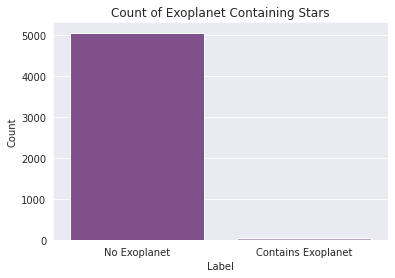

In [0]:
count_labels = train_y.groupby(by=train_y).count()
count_labels = count_labels.to_frame(name='Count')
count_labels = count_labels.reset_index()
g2 = sns.barplot(x='Label', y='Count', data=count_labels,palette=sns.color_palette("PRGn"))
g2.set(xticklabels=['No Exoplanet','Contains Exoplanet'])
plt.title('Count of Exoplanet Containing Stars')
plt.savefig('Count_stars.png',dpi=600)

In [0]:
exo_train = train_x[train_y == 1].reset_index().melt(id_vars=['index'],var_name="Flux Index", 
        value_name="Flux Intensity")
non_exo_train = train_x[train_y == 0].reset_index().melt(id_vars=['index'],var_name="Flux Index", 
        value_name="Flux Intensity")
print(exo_train.groupby('index').std().mean())
print(non_exo_train.groupby('index').std().mean())

Flux Intensity    1113.599545
dtype: float64
Flux Intensity    1267.318598
dtype: float64


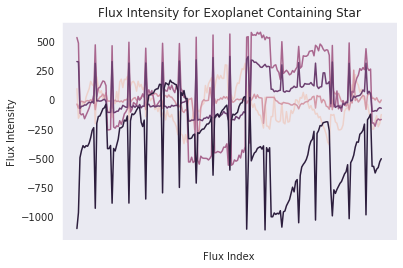

In [0]:
plot_train_df = train_x.loc[:4,:'FLUX.200'].reset_index()
plot_train_df = plot_train_df.melt(id_vars=['index'],var_name="Flux Index", 
        value_name="Flux Intensity")
sns.set_style("dark")
g = sns.lineplot(x="Flux Index", y="Flux Intensity", hue="index",
                  data=plot_train_df,legend=False)
g.set(xticklabels=[])
plt.title('Flux Intensity for Exoplanet Containing Star')
plt.savefig('Flux_Intensity.png',dpi=800)

In [0]:
corr_matrix = train_x.loc[:37,:'FLUX.10'].corr()
corr_matrix.style.background_gradient()

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10
FLUX.1,1.000000,0.999991,0.999934,0.999801,0.999594,0.998802,0.998145,0.986388,0.661413,-0.953298
FLUX.2,0.999991,1.000000,0.999970,0.999866,0.999689,0.998970,0.998343,0.986949,0.664021,-0.952280
FLUX.3,0.999934,0.999970,1.000000,0.999961,0.999847,0.999282,0.998741,0.988129,0.669639,-0.949962
FLUX.4,0.999801,0.999866,0.999961,1.000000,0.999959,0.999571,0.999137,0.989427,0.676058,-0.947216
FLUX.5,0.999594,0.999689,0.999847,0.999959,1.000000,0.999788,0.999458,0.990639,0.682391,-0.944414
FLUX.6,0.998802,0.998970,0.999282,0.999571,0.999788,1.000000,0.999904,0.993206,0.697138,-0.937551
FLUX.7,0.998145,0.998343,0.998741,0.999137,0.999458,0.999904,1.000000,0.994529,0.705667,-0.933201
FLUX.8,0.986388,0.986949,0.988129,0.989427,0.990639,0.993206,0.994529,1.000000,0.775584,-0.890843
FLUX.9,0.661413,0.664021,0.669639,0.676058,0.682391,0.697138,0.705667,0.775584,1.000000,-0.404784
FLUX.10,-0.953298,-0.952280,-0.949962,-0.947216,-0.944414,-0.937551,-0.933201,-0.890843,-0.404784,1.000000


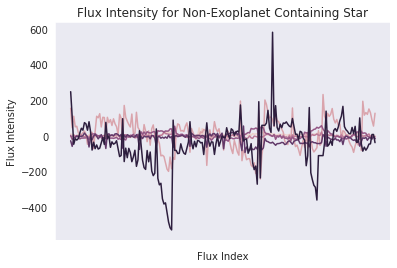

In [0]:
non_exo_df = train_x.loc[50:55,:'FLUX.200'].reset_index()
non_exo_df = non_exo_df.melt(id_vars=['index'],var_name="Flux Index", 
        value_name="Flux Intensity")
g1 = sns.lineplot(x="Flux Index", y="Flux Intensity", hue="index",
                  data=non_exo_df ,legend=False)
g1.set(xticklabels=[])
plt.title('Flux Intensity for Non-Exoplanet Containing Star')
plt.savefig('Flux_Intensity_NonExo.png',dpi=800)

In [0]:
corr_matrix = train_x.loc[38:1000,:'FLUX.10'].corr()
corr_matrix.style.background_gradient()

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10
FLUX.1,1.000000,0.977680,0.929653,0.924147,0.948202,0.962880,0.941278,0.914964,0.903705,0.934990
FLUX.2,0.977680,1.000000,0.968441,0.969030,0.983980,0.975410,0.954968,0.949872,0.951988,0.974328
FLUX.3,0.929653,0.968441,1.000000,0.994258,0.986959,0.967495,0.949533,0.954791,0.966938,0.969197
FLUX.4,0.924147,0.969030,0.994258,1.000000,0.988620,0.957567,0.929721,0.934737,0.953768,0.971627
FLUX.5,0.948202,0.983980,0.986959,0.988620,1.000000,0.986648,0.967383,0.963396,0.967637,0.980374
FLUX.6,0.962880,0.975410,0.967495,0.957567,0.986648,1.000000,0.992506,0.977249,0.965588,0.969274
FLUX.7,0.941278,0.954968,0.949533,0.929721,0.967383,0.992506,1.000000,0.990398,0.972779,0.957755
FLUX.8,0.914964,0.949872,0.954791,0.934737,0.963396,0.977249,0.990398,1.000000,0.992745,0.967661
FLUX.9,0.903705,0.951988,0.966938,0.953768,0.967637,0.965588,0.972779,0.992745,1.000000,0.982503
FLUX.10,0.934990,0.974328,0.969197,0.971627,0.980374,0.969274,0.957755,0.967661,0.982503,1.000000


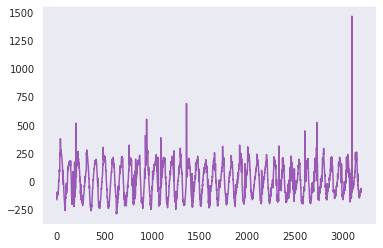

In [0]:
entry = train_x.loc[40,:].to_numpy()
plt.plot(entry)

# Modeling


### Preparing the Data

In [0]:
from scipy.ndimage.filters import uniform_filter1d
train_x = pd.DataFrame(uniform_filter1d(train_x, axis=1, size=50))
test_x = pd.DataFrame(uniform_filter1d(test_x, axis=1, size=50))

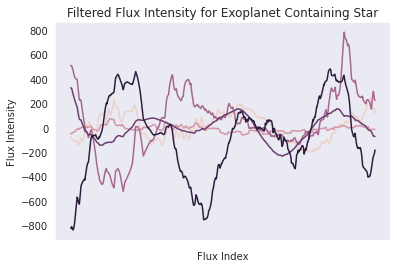

In [0]:
plot_train_df = train_x.loc[:4,:'200'].reset_index()
plot_train_df = plot_train_df.melt(id_vars=['index'],var_name="Flux Index", 
        value_name="Flux Intensity")
sns.set_style("dark")
g = sns.lineplot(x="Flux Index", y="Flux Intensity", hue="index",
                  data=plot_train_df,legend=False)
g.set(xticklabels=[])
plt.title('Filtered Flux Intensity for Exoplanet Containing Star')
plt.savefig('Filtered_Flux_Intensity.png',dpi=800)

In [0]:
from sklearn.preprocessing import StandardScaler, normalize

train_x = normalize(train_x)
test_x = normalize(test_x)

train_x = StandardScaler().fit_transform(train_x)
test_x = StandardScaler().fit_transform(test_x)

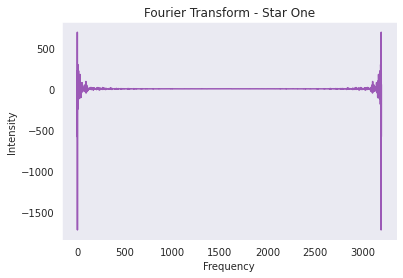

In [0]:
four_train_x = np.real(np.fft.fft(train_x,axis=1))
four_test_x = np.real(np.fft.fft(test_x,axis=1))

plt.plot(four_train_x[0,:])
plt.title('Fourier Transform - Star One')
plt.xlabel('Frequency')
plt.ylabel('Intensity')
plt.savefig('Fourier_Transform.png',dpi=800)

In [0]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
train_x_prepped, train_y_prepped = sm.fit_resample(train_x, train_y)
test_x_prepped = test_x
test_y_prepped = test_y.to_numpy()
print(sum(train_y_prepped==0), sum(train_y_prepped==1))

In [0]:
four_train_x_prepped, four_train_y_prepped = sm.fit_resample(four_train_x, train_y)
four_test_x_prepped = four_test_x
four_test_y_prepped = test_y.to_numpy()
print(sum(four_train_y_prepped==0), sum(four_train_y_prepped==1))

### Logistic Regression

In [0]:
from keras.models import Sequential
from keras.regularizers import L1L2
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD, Adam
from sklearn.model_selection import GridSearchCV
from keras.layers import Dense, Conv1D, Flatten,MaxPool1D,BatchNormalization,Dropout
from sklearn.metrics import confusion_matrix

In [0]:
train_y_prepped_oh = to_categorical(train_y_prepped)
test_y_prepped_oh = to_categorical(test_y_prepped)
four_train_y_prepped_oh = to_categorical(four_train_y_prepped)
four_test_y_prepped_oh = to_categorical(four_test_y_prepped)

In [0]:
model = Sequential()
model.add(Dense(2,activation='softmax',
                input_dim=train_x_prepped.shape[1]))
optimizer = SGD(lr=.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', 
                metrics=['accuracy'])
history = model.fit(train_x_prepped, train_y_prepped_oh,epochs=40)

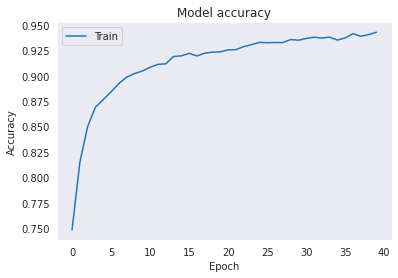

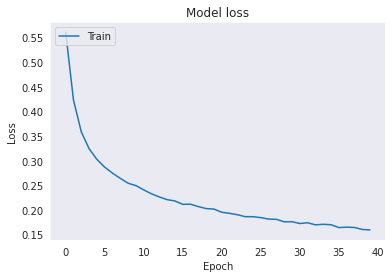

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Log_Reg_Accuracy.png',dpi=800)
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Log_Reg_Loss.png',dpi=800)
plt.show()

[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 1 0 0 0 0 0 

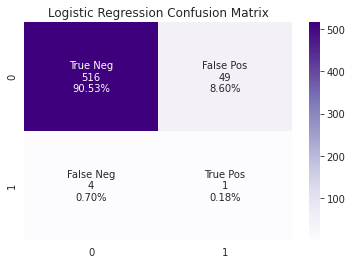

In [0]:
y_pred = np.argmax(model.predict(test_x_prepped), axis=1)
cf_matrix = confusion_matrix(test_y_prepped, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap="Purples")
plt.title('Logistic Regression Confusion Matrix')
plt.savefig('Log_Reg_Con_Mat.png',dpi=800)

In [0]:
model = Sequential()
model.add(Dense(2,activation='softmax',
                input_dim=train_x_prepped.shape[1]))
optimizer = SGD(lr=1)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', 
                metrics=['accuracy'])
history = model.fit(four_train_x_prepped, four_train_y_prepped_oh,epochs=40)

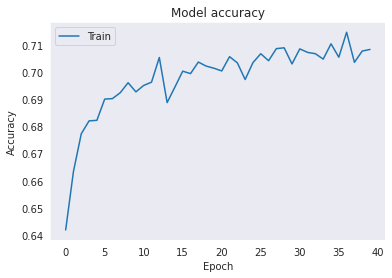

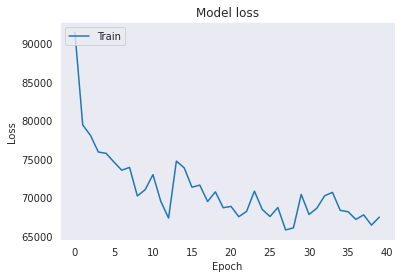

In [0]:
sns.set_palette(sns.color_palette("tab10"))
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Fourier_Log_Reg_Accuracy.png',dpi=800)
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Fourier_Log_Reg_Loss.png',dpi=800)
plt.show()

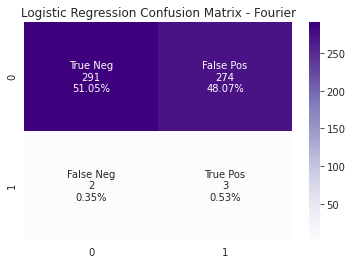

In [0]:
four_y_pred = np.argmax(model.predict(four_test_x_prepped), axis=1)
cf_matrix = confusion_matrix(test_y, four_y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap="Purples")
plt.title('Logistic Regression Confusion Matrix - Fourier')
plt.savefig('Fourier_Log_Reg_Con_Mat.png',dpi=800)

### Feed-forward Network

In [0]:
model = Sequential()
n_cols = train_x_prepped.shape[1]
model.add(Dense(200, activation='relu', input_shape=(n_cols,)))
model.add(Dense(200, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1,activation='sigmoid'))
optimizer = Adam(learning_rate=0.000001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_x_prepped, train_y_prepped,epochs=35)

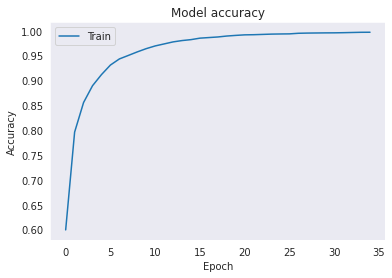

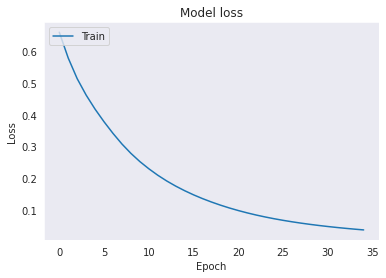

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('FF_Net_Accuracy.png',dpi=800)
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('FF_Net_Loss.png',dpi=800)
plt.show()

Crossover at 0.03 with specificity 0.62


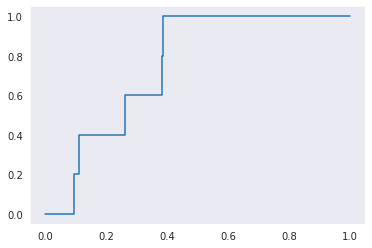

ROC area under curve is 0.75
0.030040678


In [0]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred = model.predict(test_x_prepped)
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
crossover_index = np.min(np.where(1.-fpr <= tpr))
crossover_cutoff = thresholds[crossover_index]
print(crossover_cutoff)

In [0]:
y_pred[y_pred < crossover_cutoff] = 0
y_pred[y_pred >= crossover_cutoff] = 1

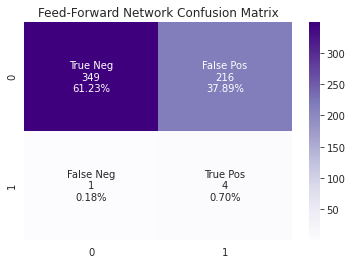

In [0]:
cf_matrix = confusion_matrix(test_y, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap="Purples")
plt.title('Feed-Forward Network Confusion Matrix')
plt.savefig('FF_Net_Con_Mat.png',dpi=800)

In [0]:
model = Sequential()
n_cols = train_x_prepped.shape[1]
model.add(Dense(200, activation='relu', input_shape=(n_cols,)))
model.add(Dense(200, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1,activation='sigmoid'))
optimizer = Adam(learning_rate=0.000001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(four_train_x_prepped, four_train_y_prepped,epochs=30)

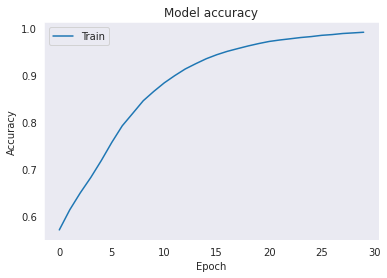

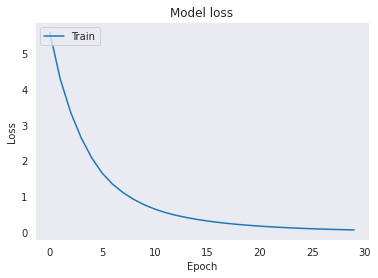

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Log_Reg_Accuracy.png',dpi=800)
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Log_Reg_Loss.png',dpi=800)
plt.show()

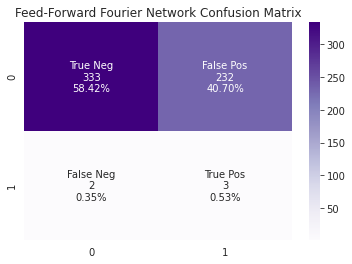

In [0]:
y_pred = model.predict(four_test_x_prepped)
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
crossover_index = np.min(np.where(1.-fpr <= tpr))
crossover_cutoff = thresholds[crossover_index]

y_pred[y_pred < crossover_cutoff] = 0
y_pred[y_pred >= crossover_cutoff] = 1

cf_matrix = confusion_matrix(test_y, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap="Purples")
plt.title('Feed-Forward Fourier Network Confusion Matrix')
plt.savefig('Four_FF_Net_Con_Mat.png',dpi=800)

### Convolutional Network

In [0]:
model = Sequential()
n_cols = train_x_prepped.shape[1]
model.add(Conv1D(filters=512, kernel_size=16, activation='relu', input_shape=(n_cols,1)))
model.add(MaxPool1D(strides=4))
model.add(Conv1D(filters=256, kernel_size=16, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(Conv1D(filters=128, kernel_size=16, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(Conv1D(filters=64, kernel_size=16, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
train_x_prepped_rs = np.expand_dims(train_x_prepped, axis=2)
test_x_prepped_rs = np.expand_dims(test_x_prepped, axis=2)
class_weight = {0: 1.,
                1: 137.}
history = model.fit(train_x_prepped_rs, train_y_prepped,epochs=25,class_weight=class_weight)

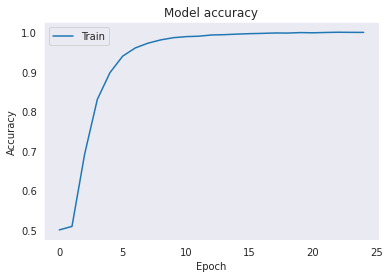

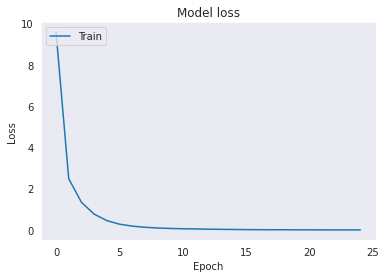

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Conv_Net_Accuracy.png',dpi=800)
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Conv_Net_Loss.png',dpi=800)
plt.show()

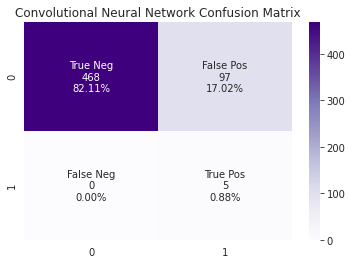

In [0]:
y_pred = model.predict(test_x_prepped_rs)

fpr, tpr, thresholds = roc_curve(test_y, y_pred)
crossover_index = np.min(np.where(1.-fpr <= tpr))
crossover_cutoff = thresholds[crossover_index]

y_pred[y_pred < crossover_cutoff] = 0
y_pred[y_pred >= crossover_cutoff] = 1
cf_matrix = confusion_matrix(four_test_y_prepped, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap="Purples")
plt.title('Convolutional Neural Network Confusion Matrix')
plt.savefig('CNN_Con_Mat.png',dpi=800)

In [0]:
model = Sequential()
n_cols = train_x_prepped.shape[1]
model.add(Conv1D(filters=512, kernel_size=16, activation='relu', input_shape=(n_cols,1)))
model.add(MaxPool1D(strides=4))
model.add(Conv1D(filters=256, kernel_size=16, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(Conv1D(filters=128, kernel_size=16, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(Conv1D(filters=64, kernel_size=16, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
four_train_x_prepped_rs = np.expand_dims(four_train_x_prepped, axis=2)
four_test_x_prepped_rs = np.expand_dims(four_test_x_prepped, axis=2)
class_weight = {0: 1.,
                1: 137.}
history = model.fit(four_train_x_prepped_rs, train_y_prepped,epochs=25,class_weight=class_weight)

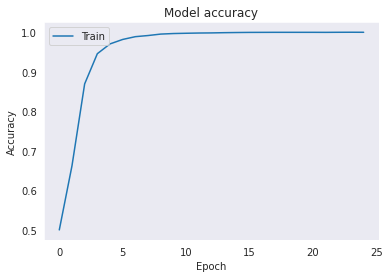

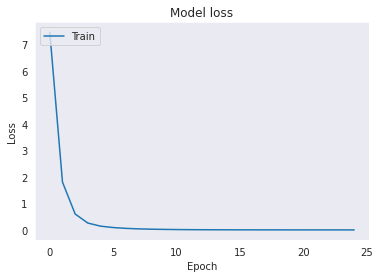

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Four_Conv_Net_Accuracy.png',dpi=800)
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Four_Conv_Net_Loss.png',dpi=800)
plt.show()

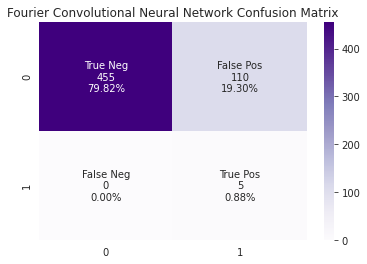

In [0]:
four_test_x_prepped_rs = np.expand_dims(four_test_x_prepped, axis=2)
y_pred = model.predict(four_test_x_prepped_rs)

fpr, tpr, thresholds = roc_curve(test_y, y_pred)
crossover_index = np.min(np.where(1.-fpr <= tpr))
crossover_cutoff = thresholds[crossover_index]

y_pred[y_pred < crossover_cutoff] = 0
y_pred[y_pred >= crossover_cutoff] = 1
cf_matrix = confusion_matrix(four_test_y_prepped, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap="Purples")
plt.title('Fourier Convolutional Neural Network Confusion Matrix')
plt.savefig('Four_CNN_Con_Mat.png',dpi=800)